In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from random import random
torch.manual_seed(0);

# From Constrained To Unconstrained Distributions

In [2]:
def derivative_lp(d_constrained, x):
    if d_constrained.support.check(x):
        _x = x.clone().requires_grad_(True)
        p = d_constrained.log_prob(_x).exp()
        p.backward()
        return _x.grad
    else:
        return torch.tensor(0.)

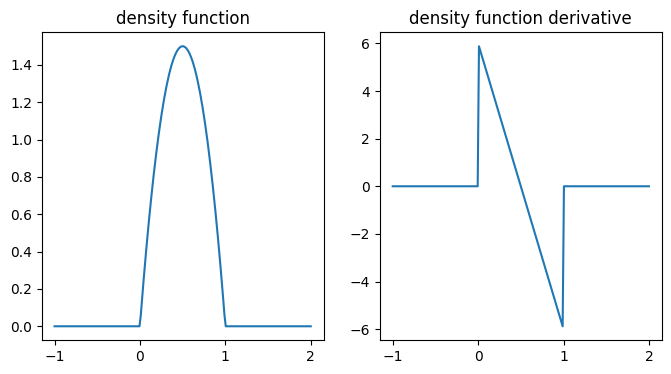

In [3]:
d_constrained = dist.Beta(2,2, validate_args=False)
xs = torch.linspace(-1,2,200)
ps = d_constrained.log_prob(xs).exp()
ps[ps.isnan()] = 0
d_ps = torch.vstack([derivative_lp(d_constrained, x) for x in xs])
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(xs, ps, label="density function")
axs[0].set_title("density function")
axs[1].plot(xs, d_ps, label="density function derivative")
axs[1].set_title("density function derivative")
plt.savefig("lecture_4_figs/constrained_derivative.pdf")

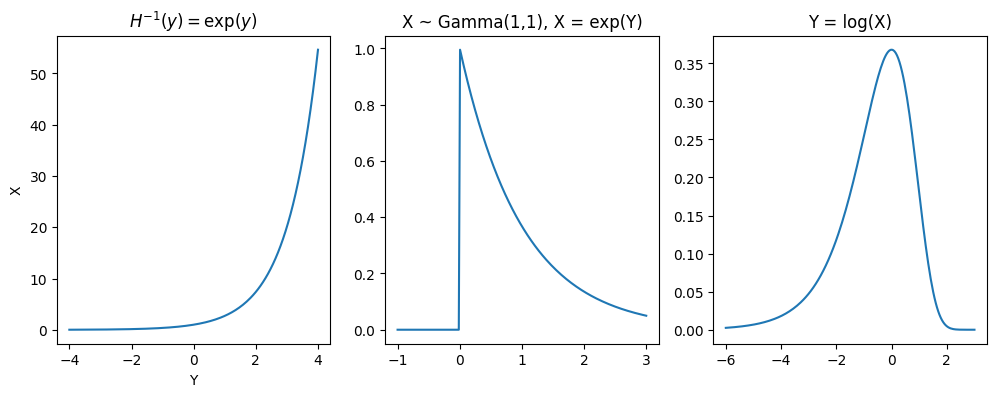

In [4]:
d_constrained = dist.Gamma(1,1)
xs = torch.linspace(-1,3,200)
ps = torch.zeros_like(xs)
ps[xs>0] = d_constrained.log_prob(xs[xs>0]).exp()
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[1].plot(xs, ps)
axs[1].set_title("X ~ Gamma(1,1), X = exp(Y)")

T = dist.transform_to(d_constrained.support)
d_unconstrained = dist.TransformedDistribution(d_constrained, T.inv)
xs = torch.linspace(-6,3,200)
ps = d_unconstrained.log_prob(xs).exp()
axs[2].plot(xs, ps)
axs[2].set_title("Y = log(X)")

xs = torch.linspace(-4,4,200)
axs[0].plot(xs, torch.exp(xs))
axs[0].set_xlabel("Y")
axs[0].set_ylabel("X")
axs[0].set_title("$H^{-1}(y) = \exp(y)$")

plt.savefig("lecture_4_figs/constraints_log.png")

In [5]:
def lp_transformed(xs, d, transform):
    ys = transform(xs)
    return d.log_prob(ys) + transform.log_abs_det_jacobian(xs, ys)

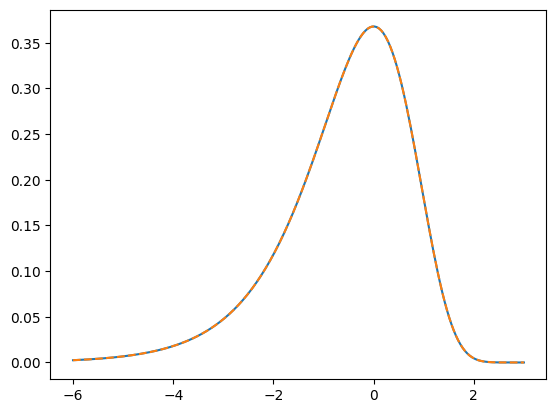

In [6]:
xs = torch.linspace(-6,3,200)
ps = lp_transformed(xs, d_constrained, T).exp()
plt.plot(xs, ps)
ps = d_constrained.log_prob(xs.exp()).exp() * torch.exp(xs)
plt.plot(xs, ps, linestyle="--")
plt.show()

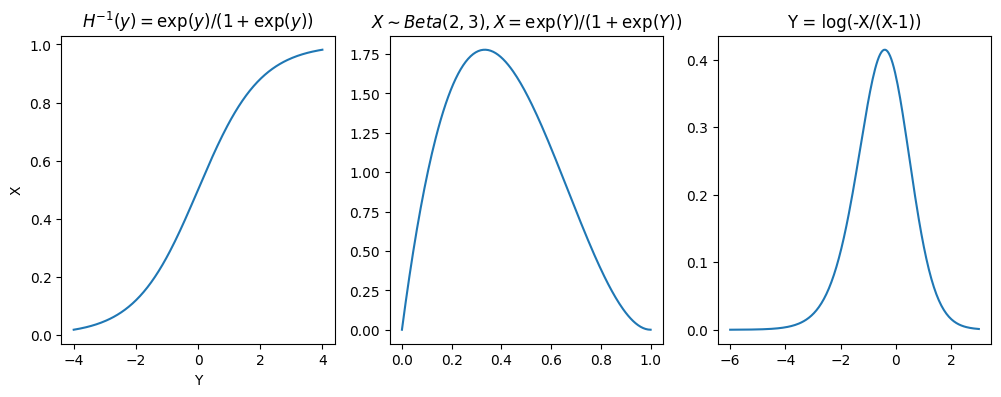

In [7]:
def sigmoid(x):
    return torch.exp(x) / (1 + torch.exp(x))

def sigmoid_prime(x):
    return torch.exp(x) / (1 + torch.exp(x))**2

d_constrained = dist.Beta(2,3)
xs = torch.linspace(0,1,200)
ps = d_constrained.log_prob(xs).exp()
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[1].plot(xs, ps)
axs[1].set_title("$X \sim Beta(2,3), X = \exp(Y) / (1+\exp(Y))$")

T = dist.transform_to(d_constrained.support)
d_unconstrained = dist.TransformedDistribution(d_constrained, T.inv)
xs = torch.linspace(-6,3,200)
ps = d_unconstrained.log_prob(xs).exp()
axs[2].plot(xs, ps)
axs[2].set_title("Y = log(-X/(X-1))")

xs = torch.linspace(-4,4,200)
axs[0].plot(xs, sigmoid(xs))
axs[0].set_xlabel("Y")
axs[0].set_ylabel("X")
axs[0].set_title("$H^{-1}(y) = \exp(y) / (1+\exp(y))$")

plt.savefig("lecture_4_figs/constraints_sigmoid.png")

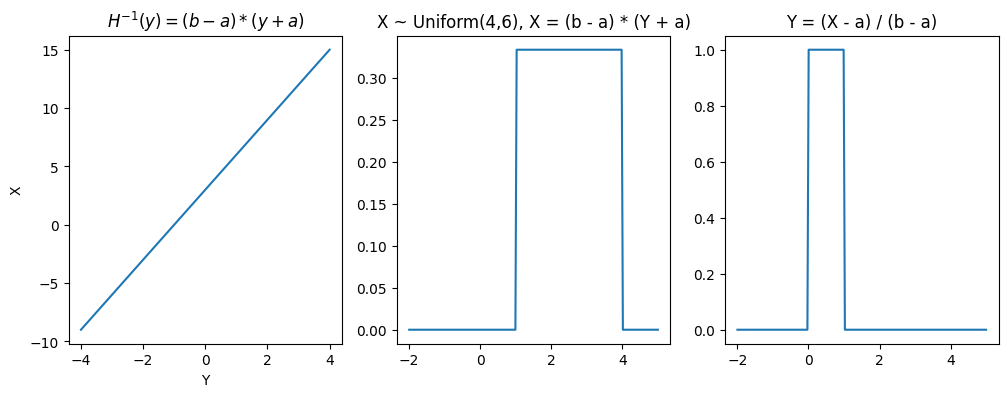

In [8]:
a = 1
b = 4
d_constrained = dist.Uniform(a,b, validate_args=False)
xs = torch.linspace(-2,5,200)
ps = d_constrained.log_prob(xs).exp()
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[1].plot(xs, ps)
axs[1].set_title("X ~ Uniform(4,6), X = (b - a) * (Y + a)")

ps = dist.Uniform(0,1,validate_args=False).log_prob(xs).exp()
axs[2].plot(xs, ps)
axs[2].set_title("Y = (X - a) / (b - a)")

xs = torch.linspace(-4,4,200)
axs[0].plot(xs,  (b - a) * (xs + a))
axs[0].set_xlabel("Y")
axs[0].set_ylabel("X")
axs[0].set_title("$H^{-1}(y) = (b - a) * (y + a)$")

plt.savefig("lecture_4_figs/constraints_linear.png")

# KL Divergence

In [9]:
from typing import Callable, Optional

def integrate(func: Callable[[torch.Tensor], torch.Tensor], a, b, N=500):
    x = torch.linspace(a, b, N)
    y = func(x)
    return torch.trapz(y, x)

def kl_divergence_1(p: dist.Distribution, q: dist.Distribution, a, b, N=500) -> torch.Tensor:
    def integrand(x: torch.Tensor) -> torch.Tensor:
        px = p.log_prob(x).exp()
        qx = q.log_prob(x).exp()
        I = px * torch.log(px / qx)
        I[px == 0] = 0
        return I
    return integrate(integrand, a, b, N)
kl_divergence = kl_divergence_1

In [10]:
def kl_divergence_2(p: dist.Distribution, q: dist.Distribution, N=500) -> torch.Tensor:
    x = p.sample((N,))
    px = p.log_prob(x).exp()
    qx = q.log_prob(x).exp()
    I = torch.log(px / qx)
    return I.mean()

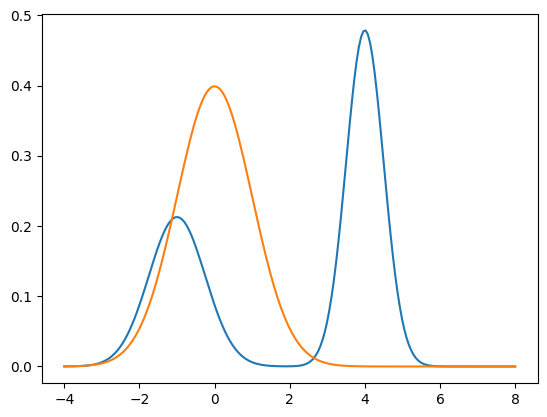

In [11]:
x = torch.linspace(-4, 8, 200)
normal_mixture = dist.MixtureSameFamily(
    dist.Categorical(torch.tensor([0.4,0.6])),
    dist.Normal(torch.tensor([-1.,4.]),torch.tensor([0.75,0.5]))
    )
plt.plot(x, normal_mixture.log_prob(x).exp())
normal = dist.Normal(0,1)
plt.plot(x, normal.log_prob(x).exp())
plt.savefig("lecture_4_figs/kl_mixture_compute.png")

In [12]:
kl_divergence_1(normal_mixture, normal, -5, 7, N=10000)

tensor(4.5455)

In [13]:
kl_divergence_2(normal_mixture, normal, N=1000000)

tensor(4.5453)

In [14]:
from scipy.optimize import dual_annealing, brute

def mode_seeking_loss(target: dist.Distribution):
    def loss(X):
        mu, sigma = X
        q = dist.Normal(mu, sigma)
        return kl_divergence(q, target, mu-4*sigma, mu+4*sigma)
        #return dist.kl_divergence(q, target)
    return loss

def mass_covering_loss(target: dist.Distribution):
    def loss(X):
        mu, sigma = X
        q = dist.Normal(mu, sigma)
        return kl_divergence(target, q, -4, 8)
        #return dist.kl_divergence(target, q)
    return loss

3.9999881377443667 0.5004358809677687


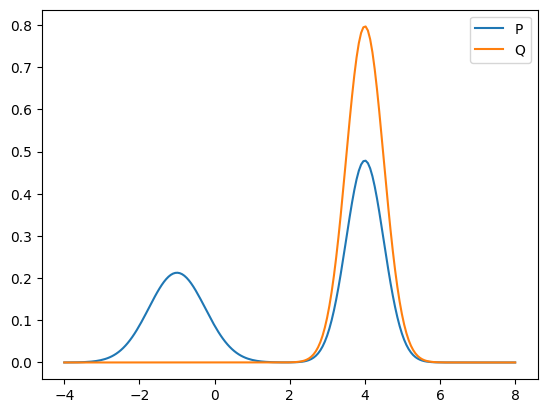

In [15]:
mu, sigma = brute(mode_seeking_loss(normal_mixture), [(-4.,8.), (0.1,3.)], Ns=100)
print(mu, sigma)

variational = dist.Normal(mu, sigma)
variational_pdf = variational.log_prob(x).exp()
plt.plot(x, normal_mixture.log_prob(x).exp(), label="P")
plt.plot(x, variational_pdf, label="Q")
plt.legend()
plt.savefig("lecture_4_figs/kl_mode_seeking.png")

2.0005128485630403 2.5248650792965464


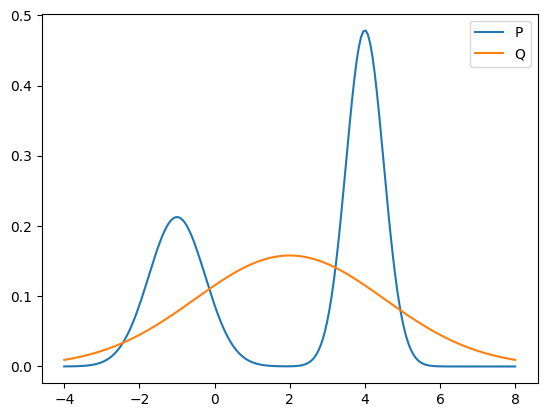

In [16]:
mu, sigma = brute(mass_covering_loss(normal_mixture), [(-4.,8.), (0.1,3.)], Ns=100)
print(mu, sigma)

variational = dist.Normal(mu, sigma)
variational_pdf = variational.log_prob(x).exp()
plt.plot(x, normal_mixture.log_prob(x).exp(), label="P")
plt.plot(x, variational_pdf, label="Q")
plt.legend()
plt.savefig("lecture_4_figs/kl_mass_covering.png")

# Variational Inference: Coin Model

In [17]:
flips = torch.tensor([0.,1.,1.,0.,0.])
prior = dist.Uniform(0,1)
posterior = dist.Beta(1 + flips.sum(), 1 + (1-flips).sum())
def likelihood(p):
    return dist.Bernoulli(p).log_prob(flips.reshape(-1,1)).sum(dim=0).exp()

T = dist.transform_to(posterior.support)
posterior_unconstrained = dist.TransformedDistribution(posterior, T.inv)
prior_uncontrained = dist.TransformedDistribution(prior, T.inv)

(-0.32971314278741637, 0.8174613262442023)

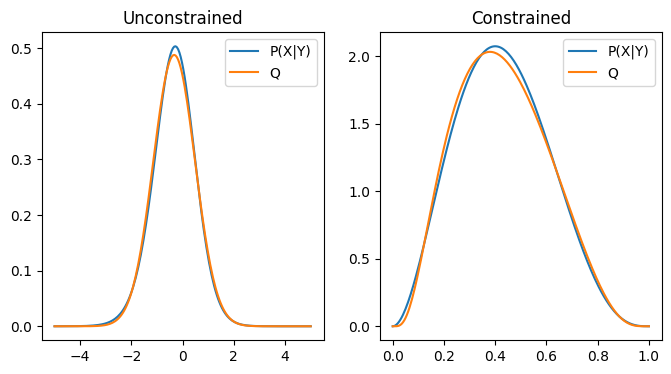

In [18]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ps = torch.linspace(-5,5,200)

axs[0].plot(ps, posterior_unconstrained.log_prob(ps).exp(), label="P(X|Y)")

def DKL_QP(X):
    mu, sigma = X
    q = dist.Normal(mu, sigma)
    return kl_divergence(q, posterior_unconstrained, mu-4*sigma, mu+4*sigma)

mu, sigma = brute(DKL_QP, [(-3,3), (0.1,1.)], Ns=100)
variational = dist.Normal(mu, sigma)
axs[0].plot(ps, variational.log_prob(ps).exp(), label="Q")
axs[0].set_title("Unconstrained")
axs[0].legend()

ps = torch.linspace(0,1,200)
axs[1].plot(ps, posterior.log_prob(ps).exp(), label="P(X|Y)")
axs[1].plot(ps, dist.TransformedDistribution(variational,T).log_prob(ps).exp(), label="Q")
axs[1].set_title("Constrained")
axs[1].legend()
plt.savefig("lecture_4_figs/vi_coin_posterior.png")
mu, sigma

(-0.32920583089192673, 0.8173004150390624)

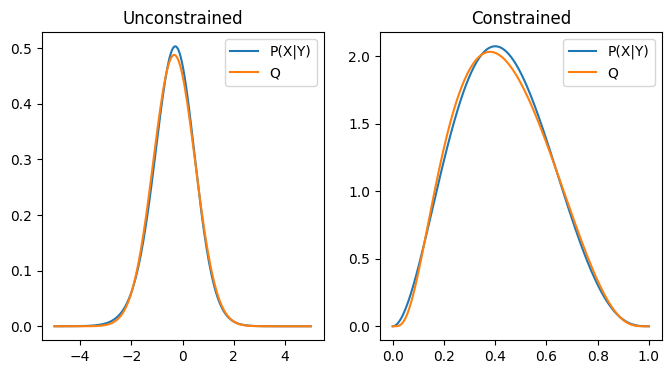

In [19]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ps = torch.linspace(-5,5,200)

axs[0].plot(ps, posterior_unconstrained.log_prob(ps).exp(), label="P(X|Y)")

def ELBO_loss(X):
    mu, sigma = X
    q = dist.Normal(mu, sigma)
    
    def integrand(x: torch.Tensor) -> torch.Tensor:
        px = likelihood(T(x)) * prior_uncontrained.log_prob(x).exp()
        qx = q.log_prob(x).exp()
        I = qx * torch.log(px / qx)
        I[px == 0] = 0
        return I
    
    return -integrate(integrand, mu-4*sigma, mu+4*sigma)

mu, sigma = brute(ELBO_loss, [(-3,3), (0.1,1.)], Ns=100)
variational = dist.Normal(mu, sigma)
axs[0].plot(ps, variational.log_prob(ps).exp(), label="Q")
axs[0].set_title("Unconstrained")
axs[0].legend()

ps = torch.linspace(0,1,200)
axs[1].plot(ps, posterior.log_prob(ps).exp(), label="P(X|Y)")
axs[1].plot(ps, dist.TransformedDistribution(variational,T).log_prob(ps).exp(), label="Q")
axs[1].set_title("Constrained")
axs[1].legend()
plt.savefig("lecture_4_figs/vi_coin_model_elbo.png")
mu, sigma

In [20]:
def log_evidence():
    def integrand(x: torch.Tensor) -> torch.Tensor:
        likelihood_x = dist.Bernoulli(T(x)).log_prob(flips.reshape(-1,1)).sum(dim=0).exp()
        prior_x = prior_uncontrained.log_prob(x).exp()
        px = likelihood_x * prior_x
        return px
    
    return torch.log(integrate(integrand, -4, 4))

log_evidence()

tensor(-4.0945)

In [21]:
mu, sigma = -1., 1.

DKL_QP([mu,sigma]) - ELBO_loss([mu,sigma]) # (approx.) equals log evidence for all mu and sigma

tensor(-4.0941)

# Automatic Differentiation

In [22]:
X = torch.tensor(2., requires_grad=True)

Y = X**2 + torch.log(X)

Y.backward() # compute gradients

X.grad.item(), (2*X + 1/X).item()

(4.5, 4.5)